In [2]:
import pandas as pd

# Load the data from the CSV file
file_path = 'Otherdata/bank-additional-full.csv'
data = pd.read_csv(file_path, delimiter=';')  # Assuming delimiter is semicolon based on common format

# Display basic information and the first few rows of the dataset
data_info = data.info()
data_head = data.head()
data_info, data_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

(None,
    age        job  marital    education  default housing loan    contact  \
 0   56  housemaid  married     basic.4y       no      no   no  telephone   
 1   57   services  married  high.school  unknown      no   no  telephone   
 2   37   services  married  high.school       no     yes   no  telephone   
 3   40     admin.  married     basic.6y       no      no   no  telephone   
 4   56   services  married  high.school       no      no  yes  telephone   
 
   month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
 0   may         mon  ...         1    999         0  nonexistent          1.1   
 1   may         mon  ...         1    999         0  nonexistent          1.1   
 2   may         mon  ...         1    999         0  nonexistent          1.1   
 3   may         mon  ...         1    999         0  nonexistent          1.1   
 4   may         mon  ...         1    999         0  nonexistent          1.1   
 
    cons.price.idx  cons.conf.idx  

In [11]:
data['cons.price.idx'].unique()

array([93.994, 94.465, 93.918, 93.444, 93.798, 93.2  , 92.756, 92.843,
       93.075, 92.893, 92.963, 92.469, 92.201, 92.379, 92.431, 92.649,
       92.713, 93.369, 93.749, 93.876, 94.055, 94.215, 94.027, 94.199,
       94.601, 94.767])

In [3]:
data_no = data[data['y'] == 'no']
data_yes = data[data['y'] == 'yes']


In [4]:
# def remove_outliers(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [5]:
# data = remove_outliers(data, 'age')


# **Yes_Split**

## **Opitimal K**

In [29]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Selecting the columns
features = ['age', 'job', 'education', 'marital', 'housing', 'loan', 'cons.price.idx', 'campaign']

# Subset the data with selected features
data_subset = data_yes[features]

# Define the column transformer: one-hot encode categorical features and scale numerical ones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'cons.price.idx', 'campaign']),
        ('cat', OneHotEncoder(), ['job', 'education', 'marital', 'housing', 'loan'])
    ])

# Fit and transform the data
data_processed = preprocessor.fit_transform(data_subset)

# Check the transformed data shape and type to confirm
data_processed.shape, type(data_processed)


((4640, 33), scipy.sparse._csr.csr_matrix)

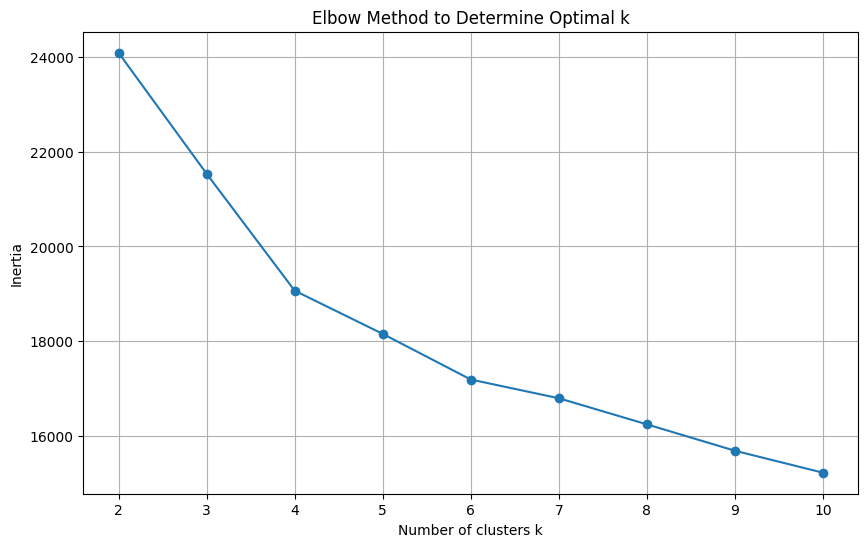

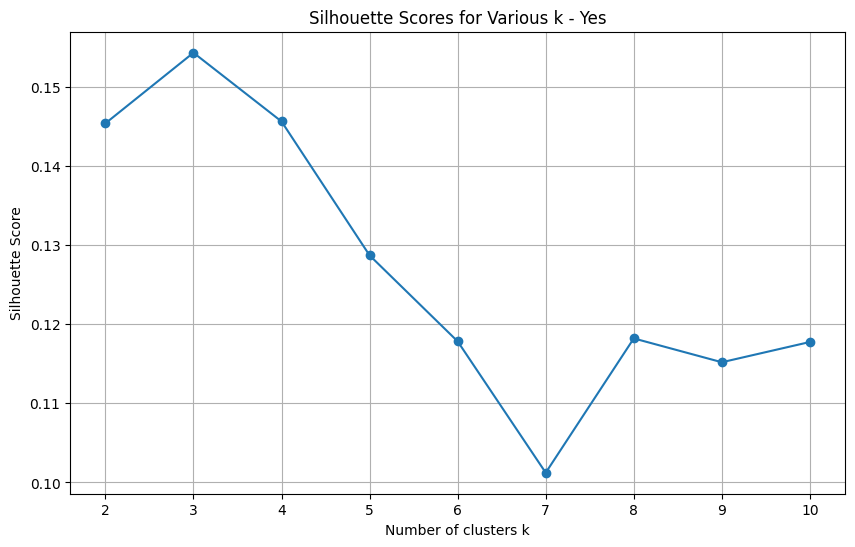

In [30]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Setting a range for possible k values
k_values = range(2, 11)  # Starting from 2 because silhouette score is not defined for k=1
inertias = []
silhouette_scores = []

# Calculate the inertia and silhouette score for each k
for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    cluster_labels = model.fit_predict(data_processed)
    inertias.append(model.inertia_)
    silhouette_scores.append(silhouette_score(data_processed, cluster_labels))

# Plotting the elbow graph for Inertia
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Various k - Yes')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()



## **Cluster Characteristics**

In [37]:
# Assuming k=3 from previous optimal k analysis or a typical starting point for exploration
k = 3
model = KMeans(n_clusters=k, random_state=42)
cluster_labels = model.fit_predict(data_processed)

# Adding cluster labels to the original DataFrame for analysis
data_yes['Cluster'] = cluster_labels

# Aggregating data to summarize cluster characteristics
cluster_summary = data_yes.groupby('Cluster').agg({
    'age': ['mean', 'median'],
    'cons.price.idx': ['mean', 'median'],
    'campaign': ['mean', 'median'],
    'job': lambda x: x.value_counts().index[0],  # Most common category
    'education': lambda x: x.value_counts().index[0],
    'marital': lambda x: x.value_counts().index[0],
    'housing': lambda x: x.value_counts().index[0],
    'loan': lambda x: x.value_counts().index[0]
})

cluster_summary


C:\Users\rbrul\AppData\Local\Temp\ipykernel_44836\2976171467.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_yes['Cluster'] = cluster_labels


age        cons.price.idx          campaign             job  \
              mean median           mean  median      mean median <lambda>   
Cluster                                                                      
0        57.526130   55.0      93.296499  93.075  1.698446    1.0  retired   
1        32.754616   33.0      93.338310  93.075  1.645597    1.0   admin.   
2        39.566176   38.0      93.666240  93.918  6.080882    5.0   admin.   

                 education  marital  housing     loan  
                  <lambda> <lambda> <lambda> <lambda>  
Cluster                                                
0        university.degree  married      yes       no  
1        university.degree   single      yes       no  
2        university.degree  married      yes       no

# **No_Split**

## **Optimal K**

In [41]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Selecting the columns
features = ['age', 'job', 'education', 'marital', 'housing', 'loan', 'cons.price.idx', 'campaign']

# Subset the data with selected features
data_subset = data_no[features]

# Define the column transformer: one-hot encode categorical features and scale numerical ones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'cons.price.idx', 'campaign']),
        ('cat', OneHotEncoder(), ['job', 'education', 'marital', 'housing', 'loan'])
    ])

# Fit and transform the data
data_processed = preprocessor.fit_transform(data_subset)

# Check the transformed data shape and type to confirm
data_processed.shape, type(data_processed)

((36548, 33), scipy.sparse._csr.csr_matrix)

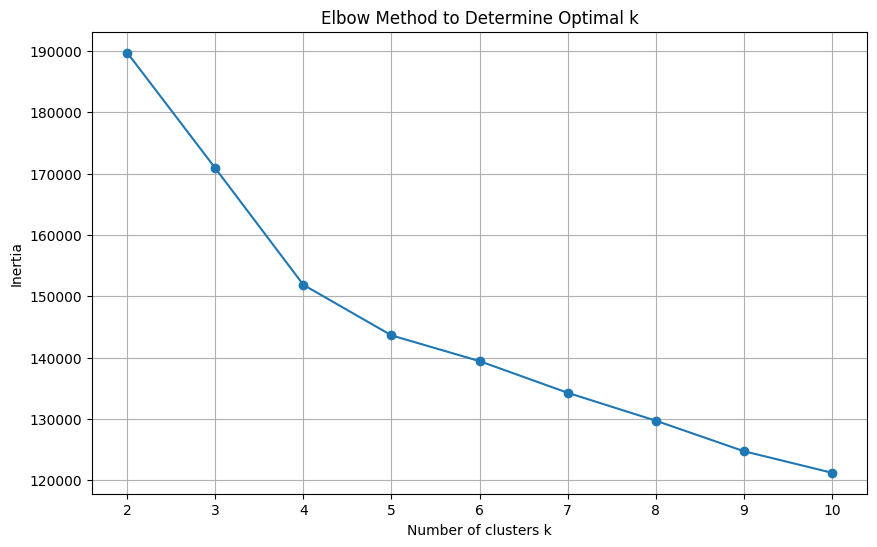

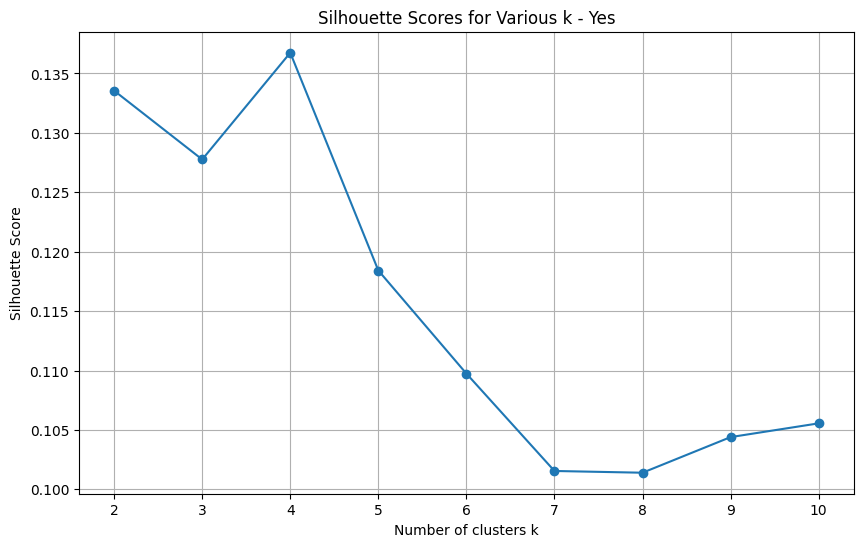

In [42]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Setting a range for possible k values
k_values = range(2, 11)  # Starting from 2 because silhouette score is not defined for k=1
inertias = []
silhouette_scores = []

# Calculate the inertia and silhouette score for each k
for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    cluster_labels = model.fit_predict(data_processed)
    inertias.append(model.inertia_)
    silhouette_scores.append(silhouette_score(data_processed, cluster_labels))

# Plotting the elbow graph for Inertia
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Various k - No')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


## **Cluster Characteristics**

In [43]:
# Assuming k=3 from previous optimal k analysis or a typical starting point for exploration
k = 3
model = KMeans(n_clusters=k, random_state=42)
cluster_labels = model.fit_predict(data_processed)

# Adding cluster labels to the original DataFrame for analysis
data_no['Cluster'] = cluster_labels

# Aggregating data to summarize cluster characteristics
cluster_summary = data_no.groupby('Cluster').agg({
    'age': ['mean', 'median'],
    'cons.price.idx': ['mean', 'median'],
    'campaign': ['mean', 'median'],
    'job': lambda x: x.value_counts().index[0],  # Most common category
    'education': lambda x: x.value_counts().index[0],
    'marital': lambda x: x.value_counts().index[0],
    'housing': lambda x: x.value_counts().index[0],
    'loan': lambda x: x.value_counts().index[0]
})

cluster_summary

C:\Users\rbrul\AppData\Local\Temp\ipykernel_44836\1195645629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no['Cluster'] = cluster_labels


age        cons.price.idx          campaign         \
              mean median           mean  median      mean median   
Cluster                                                             
0        34.809919   35.0      94.082183  93.994  3.237453    2.0   
1        34.883541   34.0      93.052715  93.075  2.122978    2.0   
2        52.256442   52.0      93.640734  93.918  2.462479    2.0   

                 job          education  marital  housing     loan  
            <lambda>           <lambda> <lambda> <lambda> <lambda>  
Cluster                                                             
0        blue-collar        high.school  married       no       no  
1             admin.  university.degree  married      yes       no  
2        blue-collar  university.degree  married      yes       no